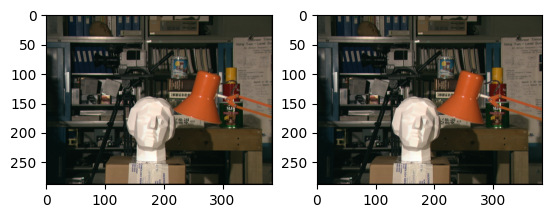

hello


In [6]:
from solution import Solution
import numpy as np
import matplotlib.pyplot as plt

img_left = plt.imread('image_left.png')
img_right = plt.imread('image_right.png')

# from PIL import Image
# img_left = Image.open('image_left.png')
# img_right = Image.open('image_right.png')
#
# #downsample the images
# img_left = img_left.resize((img_left.width//2, img_left.height//2),Image.Resampling.LANCZOS)
# img_right = img_right.resize((img_right.width//2, img_right.height//2),Image.Resampling.LANCZOS)
#


img_left = np.array(img_left)
img_right = np.array(img_right)


#show the images on one figure
plt.subplot(1, 2, 1)
plt.imshow(img_left, cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(img_right, cmap='gray')
plt.show()

print("hello")

# calculate SSDD

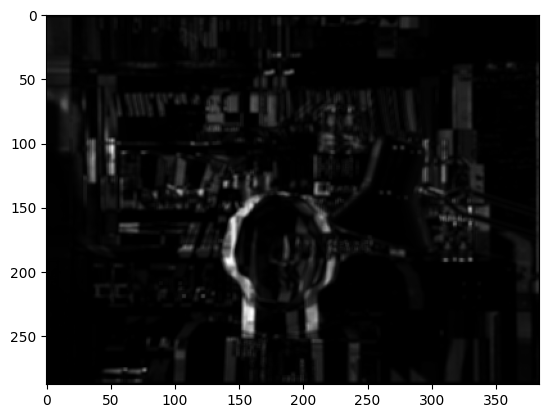

In [7]:

solution = Solution()
ssdd = solution.ssd_distance(img_left.astype(np.float64),
                             img_right.astype(np.float64),
                             win_size=3,
                             dsp_range=20)
plt.imshow(ssdd[:, :, 0], cmap='gray')
plt.show()

# naive labeling


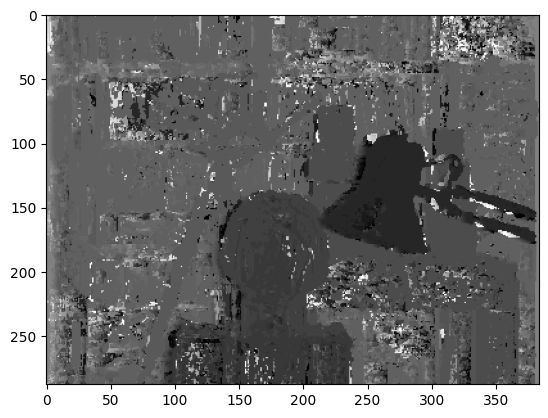

In [8]:
labling = solution.naive_labeling(ssdd)
plt.imshow(labling, cmap='gray')
plt.show()

# dynamic programming labeling

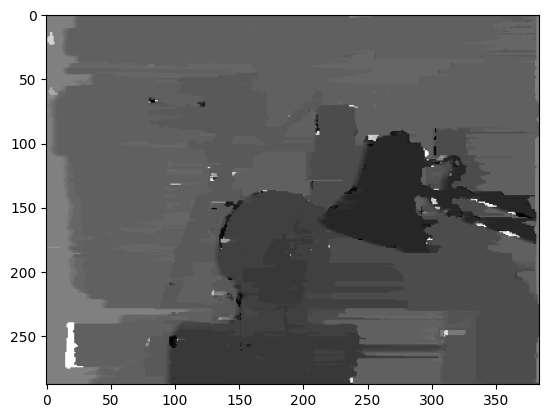

In [44]:
labling = solution.dp_labeling(ssdd, 0.5, 3.0)
plt.imshow(labling, cmap='gray')
plt.show()


In [14]:
"""Stereo matching."""
import numpy as np
from scipy.signal import convolve2d


class Solution:
    def __init__(self):
        pass

    @staticmethod
    def ssd_distance(left_image: np.ndarray,
                     right_image: np.ndarray,
                     win_size: int,
                     dsp_range: int) -> np.ndarray:
        """Compute the SSDD distances tensor.

        Args:
            left_image: Left image of shape: HxWx3, and type np.double64.
            right_image: Right image of shape: HxWx3, and type np.double64.
            win_size: Window size odd integer.
            dsp_range: Half of the disparity range. The actual range is
            -dsp_range, -dsp_range + 1, ..., 0, 1, ..., dsp_range.

        Returns:
            A tensor of the sum of squared differences for every pixel in a
            window of size win_size X win_size, for the 2*dsp_range + 1
            possible disparity values. The tensor shape should be:
            HxWx(2*dsp_range+1).
        """
        num_of_rows, num_of_cols = left_image.shape[0], left_image.shape[1]
        disparity_values = range(-dsp_range, dsp_range + 1)
        ssdd_tensor = np.zeros((num_of_rows,
                                num_of_cols,
                                len(disparity_values)))

        """INSERT YOUR CODE HERE"""

        # Define the half window size for easier indexing
        half_win = win_size // 2

        # Pad the left and right images with zeros
        left_padded = np.pad(left_image, ((half_win, half_win), (half_win, half_win), (0, 0)), mode='constant',
                             constant_values=0)
        right_padded = np.pad(right_image, ((half_win, half_win), (half_win, half_win), (0, 0)), mode='constant',
                              constant_values=0)

        # Iterate over all disparity values
        for d_idx, d in enumerate(disparity_values):
            # Shift the right image horizontally based on disparity
            if d < 0:
                shifted_right = np.pad(right_padded[:, :d, :], ((0, 0), (-d, 0), (0, 0)), mode='constant',
                                       constant_values=0)
            elif d > 0:
                shifted_right = np.pad(right_padded[:, d:, :], ((0, 0), (0, d), (0, 0)), mode='constant',
                                       constant_values=0)
            else:
                shifted_right = right_padded

            # Compute SSDD for each pixel
            for i_ in range(num_of_rows):
                for j_ in range(num_of_cols):
                    i = i_ + half_win
                    j = j_ + half_win
                    # Extract the local windows for left and shifted right images
                    left_window = left_padded[i:i + win_size, j:j + win_size, :]
                    right_window = shifted_right[i:i + win_size, j:j + win_size, :]

                    # Compute SSDD and store in the tensor
                    ssdd_tensor[i_, j_, d_idx] = np.sum((left_window - right_window) ** 2)


        """END YOUR CODE HERE"""

        ssdd_tensor -= ssdd_tensor.min()
        ssdd_tensor /= ssdd_tensor.max()
        ssdd_tensor *= 255.0
        return ssdd_tensor

    @staticmethod
    def naive_labeling(ssdd_tensor: np.ndarray) -> np.ndarray:
        """Estimate a naive depth estimation from the SSDD tensor.

        Args:
            ssdd_tensor: A tensor of the sum of squared differences for every
            pixel in a window of size win_size X win_size, for the
            2*dsp_range + 1 possible disparity values.

        Evaluate the labels in a naive approach. Each value in the
        result tensor should contain the disparity matching minimal ssd (sum of
        squared difference).

        Returns:
            Naive labels HxW matrix.
        """
        # you can erase the label_no_smooth initialization.
        label_no_smooth = np.zeros((ssdd_tensor.shape[0], ssdd_tensor.shape[1]))
        """INSERT YOUR CODE HERE"""
        label_no_smooth = np.argmin(ssdd_tensor, axis=-1)
        """END YOUR CODE HERE"""
        return label_no_smooth

    @staticmethod
    def dp_grade_slice(c_slice: np.ndarray, p1: float, p2: float) -> np.ndarray:
        """Calculate the scores matrix for slice c_slice.

        Calculate the scores slice which for each column and disparity value
        states the score of the best route. The scores slice is of shape:
        (2*dsp_range + 1)xW.

        Args:
            c_slice: A slice of the ssdd tensor.
            p1: penalty for taking disparity value with 1 offset.
            p2: penalty for taking disparity value more than 2 offset.
        Returns:
            Scores slice which for each column and disparity value states the
            score of the best route.
        """
        num_labels, num_of_cols = c_slice.shape[0], c_slice.shape[1]
        l_slice = np.zeros((num_labels, num_of_cols))
        """INSERT YOUR CODE HERE"""
        # Initialize the first colum
        l_slice[:, 0] = c_slice[:, 0]

        #loop over all other columns
        for j, c in enumerate(c_slice.T[1:], start=1):
            for d in range(num_labels):
                # thhe cost of staying in the same d
                cost_same = l_slice[d, j - 1]

                #cost of moving to d+-1
                cost_1 = float('inf')
                cost_1 = min(cost_1,
                             l_slice[d - 1, j - 1] + p1 if d - 1 >= 0 else float('inf'),
                             l_slice[d + 1, j - 1] + p1 if d + 1 < num_labels else float('inf'))
                cost_2 = float('inf')
                for k in range(2, num_labels):
                    if d - k >= 0:
                        cost_2 = min(cost_2, l_slice[d - k, j - 1] + p2)
                    if d + k < num_labels:
                        cost_2 = min(cost_2, l_slice[d + k, j - 1] + p2)


                # choose the minimum cost
                M_d_col =  min(cost_same, cost_1, cost_2)
                # update add and normalize
                l_slice[d, j] = c[d] + M_d_col - min(l_slice[:, j - 1])

        """END YOUR CODE HERE"""
        return l_slice

    def dp_labeling(self,
                    ssdd_tensor: np.ndarray,
                    p1: float,
                    p2: float) -> np.ndarray:
        """Estimate a depth map using Dynamic Programming.

        (1) Call dp_grade_slice on each row slice of the ssdd tensor.
        (2) Store each slice in a corresponding l tensor (of shape as ssdd).
        (3) Finally, for each pixel in l (along each row and column), choose
        the best disparity value. That is the disparity value which
        corresponds to the lowest l value in that pixel.

        Args:
            ssdd_tensor: A tensor of the sum of squared differences for every
            pixel in a window of size win_size X win_size, for the
            2*dsp_range + 1 possible disparity values.
            p1: penalty for taking disparity value with 1 offset.
            p2: penalty for taking disparity value more than 2 offset.
        Returns:
            Dynamic Programming depth estimation matrix of shape HxW.
        """
        l = np.zeros_like(ssdd_tensor)
        """INSERT YOUR CODE HERE"""
        for row in range(ssdd_tensor.shape[0]):
            l[row, :, :] = self.dp_grade_slice(ssdd_tensor[row, :, :].T, p1, p2).T

        """END YOUR CODE HERE"""
        return self.naive_labeling(l)

    def dp_labeling_per_direction(self,
                                  ssdd_tensor: np.ndarray,
                                  p1: float,
                                  p2: float) -> dict:
        """Return a dictionary of directions to a Dynamic Programming
        etimation of depth.

        For each direction in 1, ..., 8, calculate scores tensors
        according to dp_grade_slice and the method which allows you to
        extract slices along each direction.

        You may use helper methods (functions) that you write on your own.
        We found `np.diagonal` to be very helpful to extract diagonal slices.
        `np.unravel_index` might be helpful if you're thinking in MATLAB
        notations: it's the ind2sub equivalent.

        Args:
            ssdd_tensor: A tensor of the sum of squared differences for
            every pixel in a window of size win_size X win_size, for the
            2*dsp_range + 1 possible disparity values.
            p1: penalty for taking disparity value with 1 offset.
            p2: penalty for taking disparity value more than 2 offset.

        Returns:
            Dictionary int->np.ndarray which maps each direction to the
            corresponding dynamic programming estimation of depth based on
            that direction.
        """
        print("initiating..")
        num_of_directions = 8
        l = np.zeros_like(ssdd_tensor)
        direction_to_slice = {}
        """INSERT YOUR CODE HERE"""

        # Diagonal slices

        def diag2(ssdd_tensor, p1, p2):
            # build a depth map for the dia
            l = np.zeros_like(ssdd_tensor)
            # loop over all diagonals
            for i in range(-ssdd_tensor.shape[0] + 1,ssdd_tensor.shape[1]):
                # choose one diagonal from m + n - 1 diagonals
                array_to_slice = np.diagonal(ssdd_tensor, i, axis1=0, axis2=1)

                l_d = self.dp_grade_slice(array_to_slice, p1, p2).T
                for j in range(l_d.shape[0]):
                    if i < 0:
                        l[-i+j, j] = l_d[j]
                    else:
                        l[j, j+i] = l_d[j]
            return self.naive_labeling(l)

        def diag4(ssdd_tensor, p1, p2):
            # build a depth map for the dia
            l = np.zeros_like(ssdd_tensor)
            m = ssdd_tensor.shape[1] - 1
            # loop over all diagonals
            for i in range(-ssdd_tensor.shape[0] + 1,ssdd_tensor.shape[1]):
                # choose one diagonal from m + n - 1 diagonals
                array_to_slice =np.fliplr(ssdd_tensor).diagonal(i)

                l_d = self.dp_grade_slice(array_to_slice, p1, p2).T
                for j in range(l_d.shape[0]):
                    if i < 0:
                        l[-i+j, m-1-j] = l_d[j]
                    else:
                        l[j, m-i-j] = l_d[j]
            return self.naive_labeling(l)

        direction_to_slice[1] = self.dp_labeling(ssdd_tensor, p1, p2)
        direction_to_slice[3] = self.dp_labeling(ssdd_tensor.transpose(1, 0, 2), p1, p2).transpose(1, 0)
        direction_to_slice[5] = np.fliplr(self.dp_labeling(np.fliplr(ssdd_tensor), p1, p2))
        direction_to_slice[7] = np.flipud(self.dp_labeling(np.flipud(ssdd_tensor), p1, p2))

        direction_to_slice[2] = diag2(ssdd_tensor, p1, p2)
        direction_to_slice[4] = diag4(ssdd_tensor, p1, p2)
        direction_to_slice[6] = np.flipud(diag4(np.flipud(ssdd_tensor), p1, p2))
        direction_to_slice[8] = np.flipud(diag2(np.flipud(ssdd_tensor), p1, p2))


        """END YOUR CODE HERE   """
        return direction_to_slice


    def diag_loss(self, ssdd_tensor, p1, p2):

        # build a depth map for the dia
        l = np.zeros_like(ssdd_tensor)
        # loop over all diagonals
        for i in range(-ssdd_tensor.shape[0] + 1, ssdd_tensor.shape[1]):
            # choose one diagonal from m + n - 1 diagonals
            array_to_slice = np.diagonal(ssdd_tensor, i, axis1=0, axis2=1)

            l_d = self.dp_grade_slice(array_to_slice, p1, p2).T
            for j in range(l_d.shape[0]):
                if i < 0:
                    l[-i + j, j] = l_d[j]
                else:
                    l[j, j + i] = l_d[j]
        return l



# diagonals

initiating..


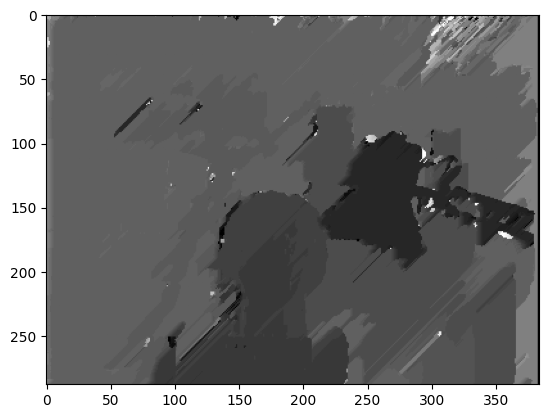

In [46]:

solution = Solution()
labling = solution.dp_labeling_per_direction(ssdd, 0.5, 3.0)
plt.imshow(labling[4], cmap='gray')


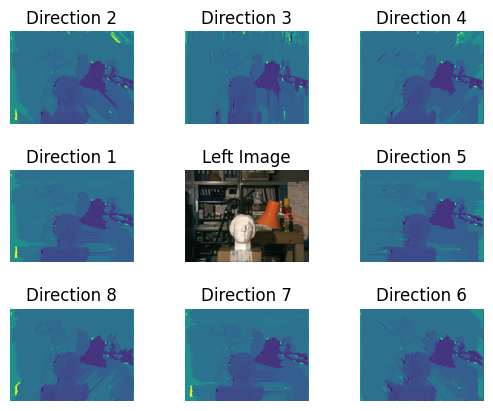

In [47]:
# show all 8 directions on a grid with labels

plt.figure()
for i in range(1, 10):
    plt.subplot(3, 3, i)
    # space between the images
    plt.subplots_adjust(hspace=0.5)
    #no axis
    plt.axis('off')
    if i <= 3:
        plt.imshow(labling[i + 1])
        plt.title(f'Direction {i+1}')
    elif i == 4:
        plt.imshow(labling[1])
        plt.title(f'Direction 1')
    elif i == 5:
        plt.imshow(img_left)
        plt.title(f'Left Image')
    elif i == 6:
        plt.imshow(labling[5])
        plt.title(f'Direction 5')
    else:
        plt.imshow(labling[15-i])
        plt.title(f'Direction {15-i}')

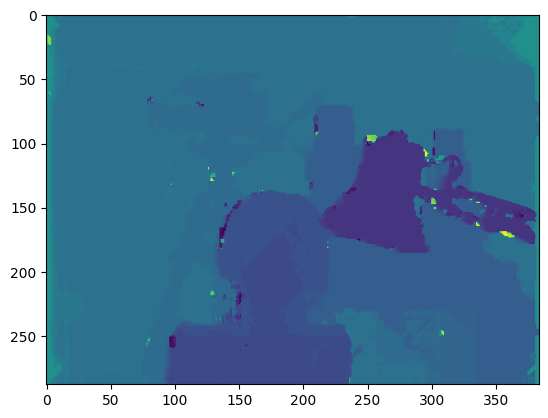

In [15]:

solution = Solution()
sgm = solution.sgm_labeling(ssdd, 0.5, 3.0)
plt.imshow(sgm)